In [14]:
import kagglehub
path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [15]:
# Imports
import os
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from PIL import Image

In [16]:
# Data directories
data_dir = os.path.join(path, "chest_xray")
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

In [17]:
# Transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [18]:
# Datasets
train_data = datasets.ImageFolder(train_dir, transform=train_transform)
test_data = datasets.ImageFolder(test_dir, transform=test_transform)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

# Validation split
val_size = int(len(train_data) * 0.2)
train_size = len(train_data) - val_size
train_subset, val_subset = random_split(train_data, [train_size, val_size])
val_loader = DataLoader(val_subset, batch_size=10, shuffle=False)

print(f"Train samples: {train_size} | Val samples: {val_size} | Test samples: {len(test_data)}")

Train samples: 4173 | Val samples: 1043 | Test samples: 624


In [19]:
# Model definition
class PneumoniaResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(PneumoniaResNet, self).__init__()
        self.model = models.resnet18(weights=None)
        for param in self.model.parameters():
            param.requires_grad = False
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    def forward(self, x):
        return self.model(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PneumoniaResNet(num_classes=2).to(device)

In [20]:
# Loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.model.fc.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

In [21]:
# Early stopping utility
class EarlyStopping:
    def __init__(self, patience=5):
        self.patience = patience
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False
    def __call__(self, val_loss):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

early_stopper = EarlyStopping(patience=5)

In [23]:
# Training & Validation
import copy
num_epochs = 22
best_model_wts = copy.deepcopy(model.state_dict())
best_val_acc = 0.0

import matplotlib.pyplot as plt

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    # Training
    model.train()
    running_loss = 0.0
    running_corrects = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    train_loss = running_loss / train_size
    train_acc = running_corrects.double() / train_size

    # Validation
    model.eval()
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            val_loss += loss.item() * inputs.size(0)
            val_corrects += torch.sum(preds == labels.data)
    val_loss = val_loss / val_size
    val_acc = val_corrects.double() / val_size

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc.item())
    val_accuracies.append(val_acc.item())

    print(f"Train loss: {train_loss:.4f}, acc: {train_acc:.4f} | Val loss: {val_loss:.4f}, acc: {val_acc:.4f}")
    scheduler.step()
    early_stopper(val_loss)
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())
    if early_stopper.early_stop:
        print("Early stopping triggered.")
        break
model.load_state_dict(best_model_wts)

Epoch 1/22
Train loss: 0.5585, acc: 0.9696 | Val loss: 0.3966, acc: 0.7948
Epoch 2/22
Train loss: 0.5343, acc: 0.9794 | Val loss: 0.3757, acc: 0.8178
Epoch 3/22
Train loss: 0.5140, acc: 0.9835 | Val loss: 0.3500, acc: 0.8360
Epoch 4/22
Train loss: 0.4960, acc: 1.0031 | Val loss: 0.3514, acc: 0.8360
Epoch 5/22
Train loss: 0.4862, acc: 1.0108 | Val loss: 0.3388, acc: 0.8523
Epoch 6/22
Train loss: 0.4731, acc: 1.0232 | Val loss: 0.3403, acc: 0.8523
Epoch 7/22
Train loss: 0.4661, acc: 1.0307 | Val loss: 0.3276, acc: 0.8581
Epoch 8/22
Train loss: 0.4432, acc: 1.0455 | Val loss: 0.3060, acc: 0.8600
Epoch 9/22
Train loss: 0.4372, acc: 1.0482 | Val loss: 0.2930, acc: 0.8600
Epoch 10/22
Train loss: 0.4387, acc: 1.0515 | Val loss: 0.2919, acc: 0.8763
Epoch 11/22
Train loss: 0.4362, acc: 1.0494 | Val loss: 0.2897, acc: 0.8782
Epoch 12/22
Train loss: 0.4079, acc: 1.0671 | Val loss: 0.2852, acc: 0.8811
Epoch 13/22
Train loss: 0.4196, acc: 1.0633 | Val loss: 0.2648, acc: 0.8907
Epoch 14/22
Train los

<All keys matched successfully>

In [24]:
# Testing
model.eval()
test_loss = 0.0
test_corrects = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        _, preds = torch.max(outputs, 1)
        test_loss += loss.item() * inputs.size(0)
        test_corrects += torch.sum(preds == labels.data)
test_loss = test_loss / len(test_data)
test_acc = test_corrects.double() / len(test_data)
print(f"Test loss: {test_loss:.4f}, acc: {test_acc:.4f}")

Test loss: 0.5371, acc: 0.7516


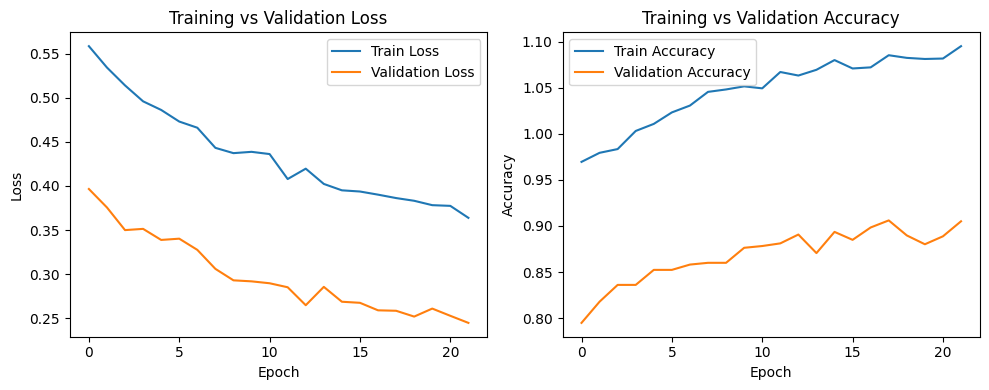

In [25]:
# Plot Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()